In [28]:
import IPython.display
from ipywidgets import interact, interactive, fixed
import scipy.constants as const
import scipy
import copy
from scipy.io import wavfile
from IPython.core.display import HTML
from __future__ import division
import pylab
import numpy as np
import matplotlib.pyplot as plt
import spectrum
from scipy.signal import butter, lfilter
import scipy.ndimage
%matplotlib inline

In [27]:
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))
    
def wavArrayPlayer(sample_rate, arr):
    wavfile.write('shooting_clip_temp.wav', sample_rate, arr)
    return wavPlayer('shooting_clip_temp.wav')


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset
    

In [3]:
sample_rate, signal = wavfile.read('shooting_v2.wav')

In [4]:
# Pull 1 dimensional signal from one speaker (the audio is stereo data -- two data streams, one for each speaker)
signal = signal[:,0]

In [5]:
signal.shape

(77143040,)

In [6]:
# Pluck out time where shooting is occuring
signal = signal[sample_rate * 481: sample_rate * 484]

In [7]:
wavArrayPlayer(sample_rate, signal)

In [8]:
# Normalize signal between 0 and 1
signal = 0.5 + signal / (2 * signal.max()) 

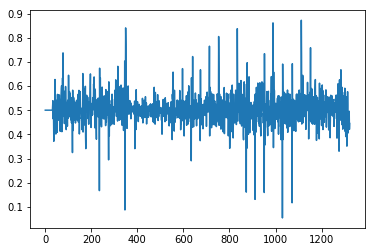

In [9]:
plt.plot(signal[::100])

In [15]:
### Parameters ###
fft_size = 2048 # window size for the FFT
step_size = fft_size//16 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from 

In [18]:
wav_spectrogram = pretty_spectrogram(signal, fft_size = fft_size, step_size = step_size, log = True, thresh = spec_thresh)

(0, 600)

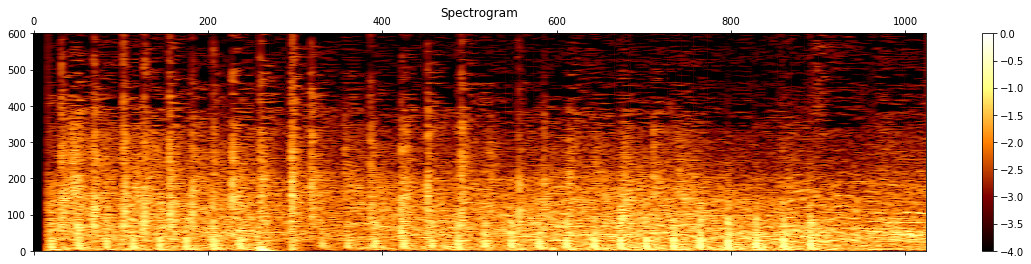

In [42]:
fig, ax = plt.subplots(figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Spectrogram')
plt.ylim(0, 600)

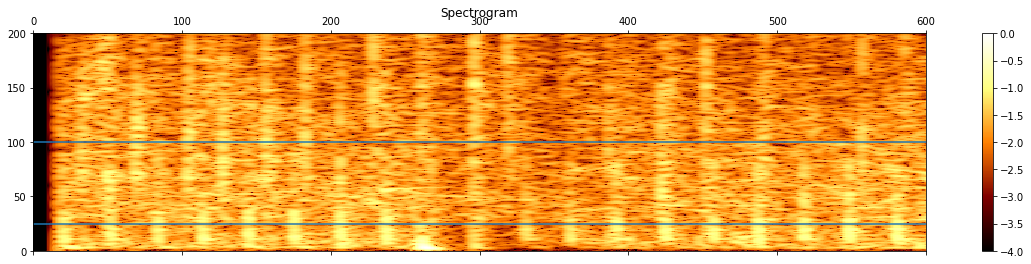

In [53]:
fig, ax = plt.subplots(figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Spectrogram')
plt.ylim(0, 200)
plt.xlim(0, 600)
plt.axhline(y=100)
plt.axhline(y=25)

## The vertical bands are the gunshots

In [45]:
# Invert from the spectrogram back to a waveform
low_freq_spectrum = wav_spectrogram.copy()
low_freq_spectrum[:, 50:] = low_freq_spectrum.min()
recovered_audio_orig = invert_pretty_spectrogram(low_freq_spectrum, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=recovered_audio_orig, rate=sample_rate) # play the audio

In [48]:
# Invert from the spectrogram back to a waveform
high_freq_spectrum = wav_spectrogram.copy()
high_freq_spectrum[:, :30] = high_freq_spectrum.min()
recovered_audio_orig = invert_pretty_spectrogram(high_freq_spectrum, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
IPython.display.Audio(data=recovered_audio_orig, rate=sample_rate)

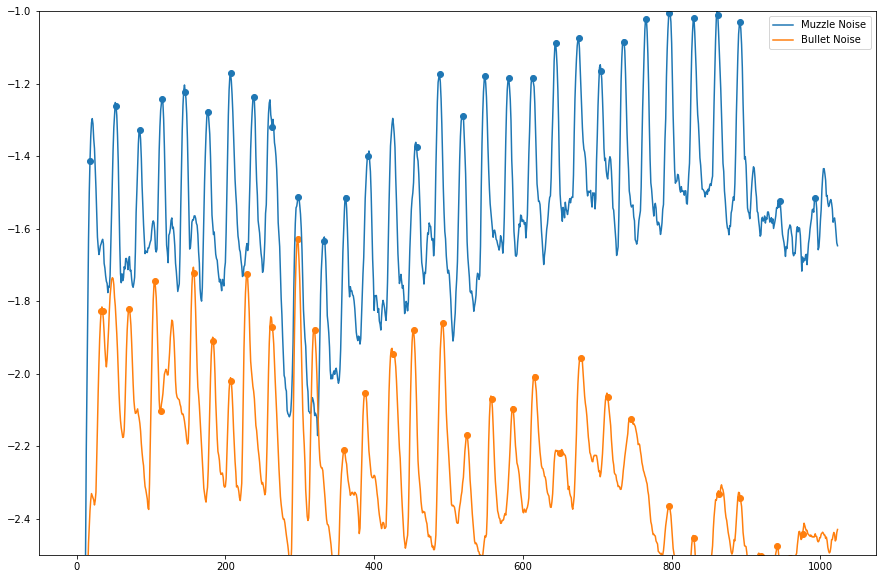

In [92]:
from scipy.signal import find_peaks_cwt
plt.figure(figsize=(15,10))
muzzle_noise = wav_spectrogram[:, 0:50].mean(axis=1)
bullet_noise = wav_spectrogram[:, 100:300].mean(axis=1)
plt.plot(muzzle_noise, label='Muzzle Noise')
plt.plot(bullet_noise, label='Bullet Noise')

muzzle_peak_indexes = find_peaks_cwt(muzzle_noise, widths=np.arange(1, 20))
plt.scatter(muzzle_peak_indexes, muzzle_noise[muzzle_peak_indexes])

bullet_peak_indexes = find_peaks_cwt(bullet_noise, widths=np.arange(1, 20))
plt.scatter(bullet_peak_indexes, bullet_noise[bullet_peak_indexes])

plt.ylim(-2.5, -1)
plt.legend()

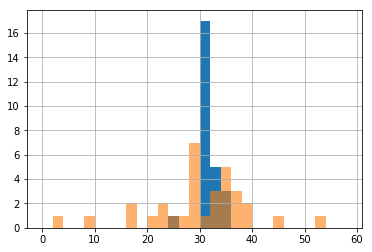

In [93]:
plt.hist(muzzle_peak_indexes[1:] - muzzle_peak_indexes[:-1], bins=np.arange(20, 40, 2))
plt.hist(bullet_peak_indexes[1:] - bullet_peak_indexes[:-1], bins=np.arange(0, 60, 2), alpha=.6)
plt.grid()

In [96]:
30 * (3 / wav_spectrogram.shape[1])

0.087890625

In [180]:
high_freq_index

102